# Final Project: Landslide Exposure of Building Infrastructures in Portland, OR 

Daniel Acosta, 2021  
CEWA 599  
Instructor: David Shean  

## Background
Based on the quantitative landslide risk equation, which is defined as risk as a function of annual probability of landslide (hazard), the spatial and spatial-time probability of a landslide impacting a building (runout and exposure), and the probability of injury or death from a given impact by a landslide (vulnerability). In this sense, a landslide exposure is defined as the analysis of elements at risk of being prone to a hazardous zone. The elements at risk refer to building footprints that match specific susceptibility classes.

Given a landslide susceptibility map, often landslide exposure has been measured using land cover maps for further risk assessment. However, a detailed landslide exposure analysis using building footprint maps is scarce. For this reason, this project explores some ways building footprint data can be utilized to assess landslide exposure in Portland, Oregon, with a focus on building infrastructures. Further research can include social and economical features of the building zones.

## Problem Statement
What is the landslide exposure of building infrastructure in the city of Portland, Oregon? The dataset to be used are:

* Landslide Susceptibility maps
* Building Footprint data

## Objective  
* Load raster data of landslide susceptibility (LS) map of Portland, Oregon
* Load the building data of Portland, Oregon
* Load the Portland neighborhood boundaries 
* Compute the LS level for each building
* Compute the landslide exposure as the area of all buildings under different LS levels

## Tools
* GDAL
* Rasterio
* NumPy
* Matplotlib

## Tools

In [4]:
import os
import requests
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio as rio
from rasterio import plot, mask
from rasterio.warp import calculate_default_transform, reproject, Resampling
import matplotlib.pyplot as plt
import rasterstats

/srv/conda/envs/notebook/lib/python3.8/site-packages/rasterio/plot.py:263: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if len(arr.shape) is 2:


In [5]:
from osgeo import gdal
import rasterio as rio
import rasterio.plot

In [6]:
%matplotlib inline

In [7]:
# Define projection:
proj = 'EPSG:32610'

## Part 1: Loading raster data  
Using Raster basic to open downloaded image from disk

In [8]:
%pwd

'/home/jovyan/landslide_exposure_portland'

In [9]:
path = r'project_data/Portland_LSM.tif'

In [10]:
with rio.open(path) as src:
    print(src.profile)

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 65535.0, 'width': 3196, 'height': 2532, 'count': 1, 'crs': CRS.from_epsg(2994), 'transform': Affine(32.80839896745932, 0.0, 704567.5157,
       0.0, -32.808398933649286, 1431484.1683), 'tiled': False, 'interleave': 'band'}


In [11]:
ls = rio.open(path)

In [12]:
ls.count

1

In [13]:
ls.meta

{'driver': 'GTiff',
 'dtype': 'uint16',
 'nodata': 65535.0,
 'width': 3196,
 'height': 2532,
 'count': 1,
 'crs': CRS.from_epsg(2994),
 'transform': Affine(32.80839896745932, 0.0, 704567.5157,
        0.0, -32.808398933649286, 1431484.1683)}

In [14]:
a = ls.read(1)

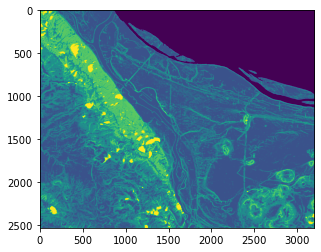

In [15]:
f, ax=plt.subplots()
ax.imshow(a);

### Open raster data into NumPy array

In [16]:
im = gdal.Open(path)
gdal_im = im.GetRasterBand(1)
r = gdal_im.ReadAsArray()
r

array([[3, 3, 3, ..., 0, 0, 0],
       [3, 3, 3, ..., 0, 0, 0],
       [3, 3, 3, ..., 0, 0, 0],
       ...,
       [2, 2, 2, ..., 3, 2, 2],
       [1, 1, 2, ..., 3, 3, 2],
       [1, 1, 1, ..., 3, 3, 2]], dtype=uint16)

In [17]:
with rio.open(path) as red:
    r1 = red.read(1)
r1

array([[3, 3, 3, ..., 0, 0, 0],
       [3, 3, 3, ..., 0, 0, 0],
       [3, 3, 3, ..., 0, 0, 0],
       ...,
       [2, 2, 2, ..., 3, 2, 2],
       [1, 1, 2, ..., 3, 3, 2],
       [1, 1, 1, ..., 3, 3, 2]], dtype=uint16)

### Eliminate nondata values

In [18]:
import numpy.ma as ma
mask = ma.masked_equal(r, 0)
mask

masked_array(
  data=[[3, 3, 3, ..., --, --, --],
        [3, 3, 3, ..., --, --, --],
        [3, 3, 3, ..., --, --, --],
        ...,
        [2, 2, 2, ..., 3, 2, 2],
        [1, 1, 2, ..., 3, 3, 2],
        [1, 1, 1, ..., 3, 3, 2]],
  mask=[[False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],
  fill_value=0,
  dtype=uint16)

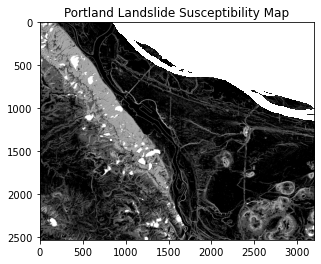

In [19]:
f, ax = plt.subplots()
ax.imshow(mask, cmap = 'gray')
ax.set_title('Portland Landslide Susceptibility Map');

### Histogram of raster data

In [20]:
ls_masked = np.ravel(mask)
ls_masked

masked_array(data=[3, 3, 3, ..., 3, 3, 2],
             mask=[False, False, False, ..., False, False, False],
       fill_value=0,
            dtype=uint16)

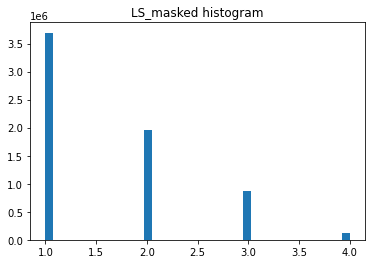

In [21]:
plt.hist(ls_masked, bins = 40)
plt.title('LS_masked histogram')
plt.show()

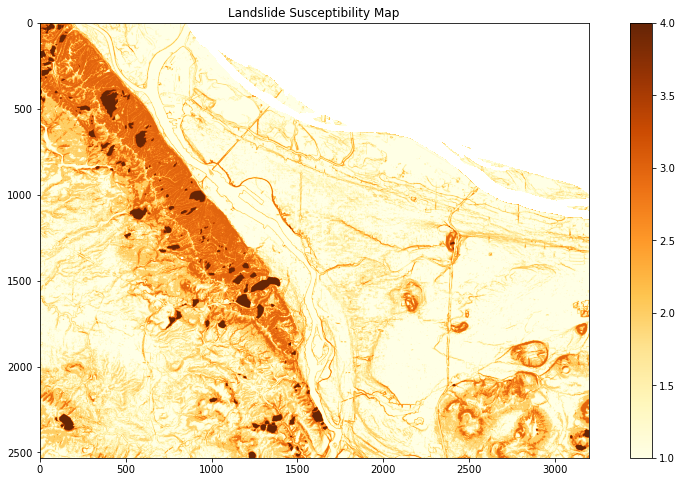

In [22]:
# Plot with coloramp
%matplotlib inline
f, ax = plt.subplots(figsize=(15,8))
lsmap = ax.imshow(mask, cmap='YlOrBr')
f.colorbar(lsmap, ax=ax)
ax.set_title('Landslide Susceptibility Map');

## Part 2: Loading Portland neighborhood boundaries polygons  
Using rasterio to load vector data

In [23]:
%pwd

'/home/jovyan/landslide_exposure_portland'

In [24]:
neigh = 'project_data/portland_neighborhoods_boundaries.gpkg'

In [25]:
n = gpd.read_file(neigh)
n

/srv/conda/envs/notebook/lib/python3.8/site-packages/geopandas/geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


,OBJECTID,NAME,COMMPLAN,SHARED,COALIT,HORZ_VERT,Shape_Leng,MAPLABEL,ID,geometry
0,1,LINNTON,None,N,NWNW,HORZ,52741.719772,Linnton,1,"MULTIPOLYGON (((-13672672.739 5717458.926, -13..."
1,2,FOREST PARK/LINNTON,None,Y,NWNW,None,57723.635350,Forest Park/Linnton,2,"MULTIPOLYGON (((-13672615.072 5717458.598, -13..."
2,3,FOREST PARK,None,N,NWNW,HORZ,82725.497522,Forest Park,3,"MULTIPOLYGON (((-13669096.892 5708277.357, -13..."
3,4,CATHEDRAL PARK,None,N,NPNS,HORZ,11434.254777,Cathedral Park,4,"MULTIPOLYGON (((-13666093.373 5714122.821, -13..."
4,5,UNIVERSITY PARK,None,N,NPNS,HORZ,11950.859827,University Park,5,"MULTIPOLYGON (((-13663193.115 5713925.450, -13..."
...,...,...,...,...,...,...,...,...,...,...
125,126,KENTON,ALBINA,N,NPNS,HORZ,19247.188225,Kenton,126,"MULTIPOLYGON (((-13656518.251 5712854.259, -13..."
126,127,BRIDGETON,None,N,NPNS,HORZ,8635.720662,Bridgeton,127,"MULTIPOLYGON (((-13654119.219 5716859.597, -13..."
127,128,EAST COLUMBIA,None,N,NPNS,HORZ,15397.269131,East Columbia,128,"MULTIPOLYGON (((-13654465.933 5716396.064, -13..."
128,129,SUNDERLAND ASSOCIATION OF NEIGHBORS,None,N,CNN,HORZ,20706.496916,Sunderland,129,"MULTIPOLYGON (((-13652256.730 5716663.111, -13..."


In [26]:
n.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World - 85°S to 85°N
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<AxesSubplot:>

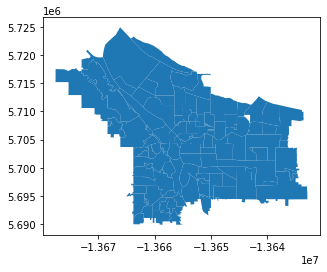

In [27]:
n.plot()

In [28]:
def rio_reproj_write(src, proj_fn, dst_crs, driver='GTiff'):
    #Check to see if output filename already exists
    if os.path.exists(proj_fn):
        print("File exists: ", proj_fn)
    else:
        #Get the required transformation and output width and height
        transform, width, height = calculate_default_transform(src.crs, dst_crs, src.width, src.height, *src.bounds)
        #Create a copy of input metadata, then update with output values
        kwargs = src.meta.copy()
        print("Source metadata:\n", kwargs)
        kwargs.update({'crs':dst_crs,'transform':transform,'width':width,'height':height})
        kwargs['driver'] = driver
        #Set output creation options
        kwargs['compress'] = 'LZW'
        kwargs['tiled'] = True
        kwargs['BIGTIFF'] = 'IF_SAFER'
        print("Destination metadata:\n", kwargs)

        #Open the destination dataset in write mode
        with rio.open(proj_fn, 'w', **kwargs) as dst:
            print("Writing: ", proj_fn)
            #Loop through each input band
            for i in range(1, src.count + 1):
                #Reproject!
                reproject(source=rio.band(src, i), destination=rio.band(dst, i), src_transform=src.transform,\
                          src_crs=src.crs, dst_transform=transform, dst_crs=dst_crs, resampling=Resampling.cubic)
            print("Complete")

In [34]:
src = rio.open(path)
proj_fn = os.path.splitext(path)[0]+'_utm_riowarp1.tif'
rio_reproj_write(src, proj_fn, proj)

Source metadata:
 {'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 65535.0, 'width': 3196, 'height': 2532, 'count': 1, 'crs': CRS.from_epsg(2994), 'transform': Affine(32.80839896745932, 0.0, 704567.5157,
       0.0, -32.808398933649286, 1431484.1683)}
Destination metadata:
 {'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 65535.0, 'width': 3272, 'height': 2628, 'count': 1, 'crs': 'EPSG:32610', 'transform': Affine(9.995920557111234, 0.0, 509599.63512493187,
       0.0, -9.995920557111234, 5056464.124063941), 'compress': 'LZW', 'tiled': True, 'BIGTIFF': 'IF_SAFER'}
Writing:  project_data/Portland_LSM_utm_riowarp1.tif
Complete


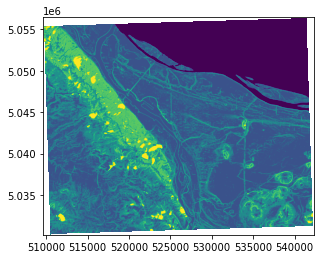

In [35]:
with rio.open(proj_fn) as src_proj:
    rio.plot.show(src_proj)

In [36]:
#Load as a masked array
src_proj = rio.open(proj_fn)
ls_proj = src_proj.read(1, masked=True)

In [37]:
# Getting extent of masked raster array
ls_extent = rio.plot.plotting_extent(src_proj)

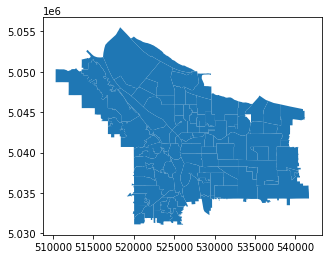

In [38]:
# Reprojecting neighborhood boundaries
n_rp = n.to_crs(proj)

# Plotting
n_rp.plot();

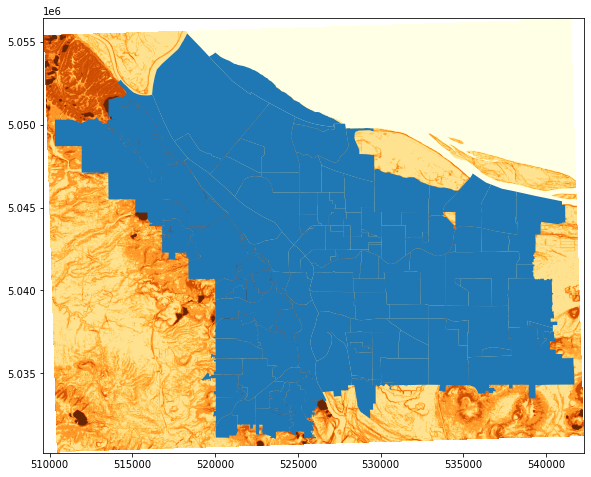

In [39]:
f, ax = plt.subplots(figsize=(15,8))
ax.imshow(ls_proj, cmap='YlOrBr', extent=ls_extent)
n_rp.plot(ax=ax);

In [40]:
# Geometry variable
po_geom = n_rp.geometry
po_geom

0      MULTIPOLYGON (((513747.148 5050305.636, 513751...
1      MULTIPOLYGON (((513787.545 5050305.496, 513796...
2      MULTIPOLYGON (((516268.709 5043897.792, 516189...
3      MULTIPOLYGON (((518362.864 5047987.762, 518028...
4      MULTIPOLYGON (((520395.714 5047856.199, 520611...
                             ...                        
125    MULTIPOLYGON (((525076.331 5047124.948, 524802...
126    MULTIPOLYGON (((526745.767 5049929.252, 527148...
127    MULTIPOLYGON (((526504.247 5049604.548, 526552...
128    MULTIPOLYGON (((528051.151 5049797.770, 528099...
129    MULTIPOLYGON (((522782.965 5047950.654, 522783...
Name: geometry, Length: 130, dtype: geometry

In [41]:
# Clip for Portland Nieghborhoods
rio_mask_kwargs = {'filled':False, 'crop':True, 'indexes':1}
po_ma, po_ma_transform = rio.mask.mask(src_proj, po_geom, **rio_mask_kwargs)

In [42]:
po_ma.shape

(2449, 3140)

In [43]:
po_ma_transform

Affine(9.995920557111234, 0.0, 510319.3414050439,
       0.0, -9.995920557111234, 5055524.507531572)

In [44]:
#Get clipped extent in UTM coordaintes
po_ma_extent = rio.plot.plotting_extent(po_ma, po_ma_transform)
po_ma_extent

(510319.3414050439, 541706.5319543732, 5031044.498087207, 5055524.507531572)

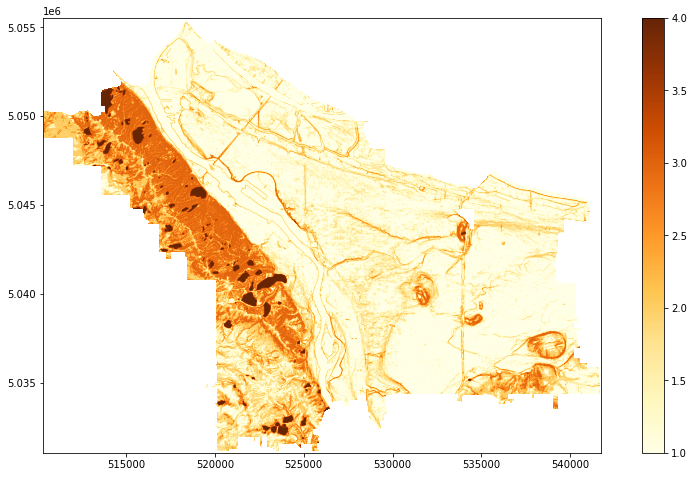

In [45]:
f, ax = plt.subplots(figsize=(15,8))
po_map = ax.imshow(po_ma, extent=po_ma_extent, cmap = 'YlOrBr', vmin=1, vmax=4)
f.colorbar(po_map, ax=ax);

## Part 3: Loading building footprint

In [46]:
bfoot = 'project_data/portland_building_footprint.gpkg'

In [47]:
b = gpd.read_file(bfoot)
b

/srv/conda/envs/notebook/lib/python3.8/site-packages/geopandas/geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


,OBJECTID,BLDG_ID,STATE_ID,BLDG_NUMB,BLDG_STAT,BLDG_NAME,BLDG_ADDR,BLDG_TYPE,BLDG_USE,BLDG_SQFT,...,ORIENT,VOLUME,Shape_Leng,Shape_Area,PROPKEY,EDIT_STAT,DATA_SOURC,RETIRED_BY,RETIRED_DA,geometry
0,80,1N1W01DA-7900-B1,1N1W01DA 7900,1.0,EXISTING,8135 N OLYMPIA ST,8135 N OLYMPIA ST,House,Single Family Residential,1324.0,...,NaN,24408.0,82.255414,310.967219,653404.0,CURRENT,PDX,None,None,"MULTIPOLYGON (((-13664023.843 5716110.710, -13..."
1,82,1N1E07CA-7800-B2,1N1E07CA 7800,2.0,EXISTING,6711 N AMHERST ST,6711 N AMHERST ST,Garage,Single Family Residential,554.0,...,NaN,4875.0,44.618188,121.956227,653406.0,CURRENT,PDX,None,None,"MULTIPOLYGON (((-13663140.644 5713654.765, -13..."
2,89,1N1W01CB-3200-B1,1N1W01CB 3200,1.0,EXISTING,9665 N KELLOGG ST,9665 N KELLOGG ST,House,Single Family Residential,1384.0,...,120.763000,19414.0,81.154237,300.281235,653413.0,CURRENT,PDX,None,None,"MULTIPOLYGON (((-13665539.575 5715962.379, -13..."
3,163,2N1W26-800-B21,2N1W26 800,21.0,EXISTING,14400 N RIVERGATE BLVD,14400 N RIVERGATE BLVD,None,Single Family Residential,2325.0,...,71.388298,51175.0,84.873482,442.060692,653488.0,CURRENT,PDX,None,None,"MULTIPOLYGON (((-13668087.946 5720924.525, -13..."
4,176,1N1W01BD-5800-B1,1N1W01BD 5800,1.0,EXISTING,10016 N JAMES ST,10016 N JAMES ST,House,Single Family Residential,688.0,...,-159.205002,15177.0,63.291208,205.587118,653501.0,CURRENT,PDX,None,None,"MULTIPOLYGON (((-13665270.868 5716671.006, -13..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247195,243684,1N1E11CB-400-B3,1N1E11CB 400,3.0,EXISTING,None,None,None,None,NaN,...,NaN,NaN,16.477285,15.423422,1322707.0,CURRENT,PDX,None,None,"MULTIPOLYGON (((-13654344.664 5713553.735, -13..."
247196,243685,1N1E11CB-400-B4,1N1E11CB 400,4.0,EXISTING,None,None,None,None,NaN,...,NaN,NaN,16.449943,15.588061,1322708.0,CURRENT,PDX,None,None,"MULTIPOLYGON (((-13654312.691 5713629.369, -13..."
247197,243686,1N1E11CB-400-B5,1N1E11CB 400,5.0,EXISTING,None,None,None,None,NaN,...,NaN,NaN,16.450143,15.588337,1322709.0,CURRENT,PDX,None,None,"MULTIPOLYGON (((-13654452.826 5713687.854, -13..."
247198,243687,1N1E11CB-400-B6,1N1E11CB 400,6.0,EXISTING,None,None,None,None,NaN,...,NaN,NaN,16.449627,15.587336,1322710.0,CURRENT,PDX,None,None,"MULTIPOLYGON (((-13654451.532 5713598.745, -13..."


In [48]:
b.total_bounds

array([-13677551.185 ,   5689879.171 , -13632943.7533,   5724379.2045])

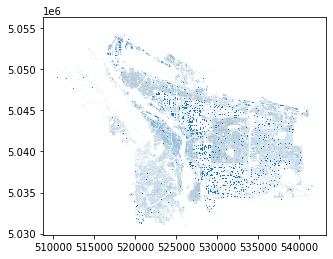

In [49]:
# Reprojecting polygons
b_rp = b.to_crs(proj)
b_rp.plot();

In [50]:
# Plot of all data
%matplotlib widget
f, ax = plt.subplots(figsize=(15,8))
po_map = ax.imshow(po_ma, extent=po_ma_extent, cmap = 'YlOrBr', vmin=1, vmax=4)
f.colorbar(po_map, ax=ax)
n_bound = n_rp.plot(ax=ax, facecolor='None', edgecolor='k', alpha=0.5, lw=0.5)
build = b_rp.plot(ax=ax, alpha=0.5)
ax.set_title('Portland LSM and Building Footprint Map');

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## Part IV: Statistics applied to Building Footprint  
* Count number of polygons
* Explore the "BLDG_USE" column and create new DataFrame for each
* Calculate the area of the polygons
* Assign LS index to each polygon using centroid or median buffer

In [51]:
b_rp.shape

(247200, 43)

In [52]:
# sfr_idx = b_rp['BLDG_USE']=='Single Family Residential'

In [53]:
# b_rp[~sfr_idx]

In [54]:
b_rp['BLDG_USE'].value_counts()

Single Family Residential    223162
Multi Family Residential      16297
Not Set                         707
Commercial Office               628
Industrial                      528
Commercial Retail               384
Institutional                   159
Commercial Restaurant           134
Parking                         110
Vacant                           87
Commercial Hotel                 54
Institutional Religious          36
Commercial General                6
Commercial Grocery                3
TOWNHOUSE                         1
Name: BLDG_USE, dtype: int64

In [55]:
# b_rp['BLDG_TYPE'].value_counts()

In [56]:
# Mask clipped raster data
ls_ma = ma.masked_equal(po_ma, 0)
ls_ma

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=0,
  dtype=uint16)

In [57]:
# plt.hist(ls_ma, bins = 40)

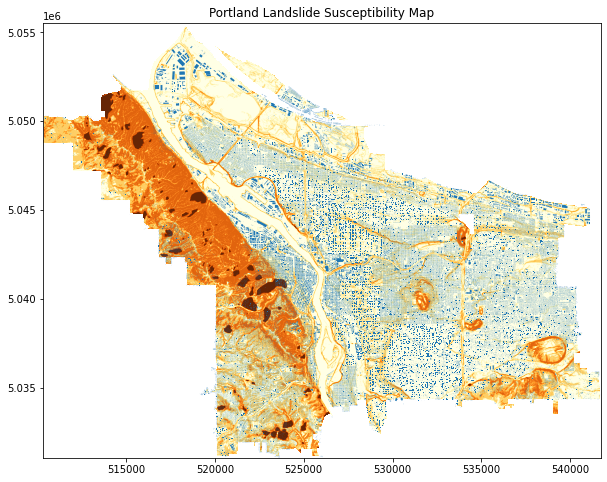

In [58]:
%matplotlib inline
f, ax = plt.subplots(figsize=(15,8))
ax.imshow(ls_ma, extent=po_ma_extent, cmap = 'YlOrBr')
ax.set_title('Portland Landslide Susceptibility Map')
b_rp.plot(ax=ax);

### Isolate Residential Properties: Single and Multi family

In [59]:
b_sinfam = b_rp.loc[b_rp['BLDG_USE'] == 'Single Family Residential']
b_mulfam = b_rp.loc[b_rp['BLDG_USE'] == 'Multi Family Residential']

In [60]:
# Number of single and multi family buildings
print('The number of residential single familiy is', len(b_sinfam), 'and multi family is', len(b_mulfam))

The number of residential single familiy is 223162 and multi family is 16297


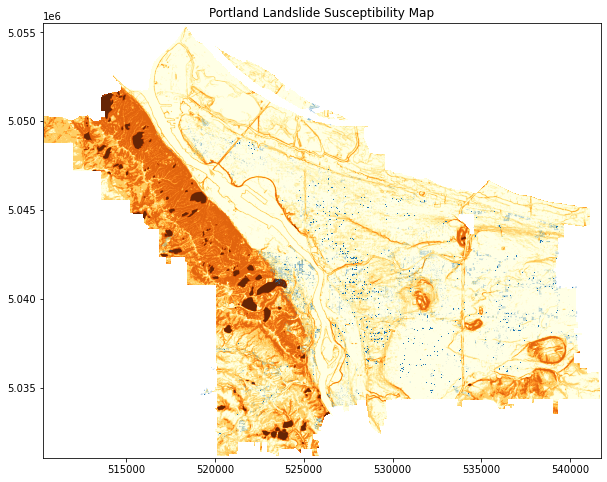

In [61]:
# Plot only single family
%matplotlib inline
f, ax = plt.subplots(figsize=(15,8))
ax.imshow(ls_ma, extent=po_ma_extent, cmap = 'YlOrBr')
ax.set_title('Portland Landslide Susceptibility Map')
b_mulfam.plot(ax=ax);

In [62]:
# Reducing data to Building Type (BLDG_TYPE), Reported SQFT (BLDG_SQFT), and geometry feature
# b: building; sinfam: Single Family; r: reduced
b_sinfam_r = b_sinfam[['BLDG_TYPE', 'BLDG_USE', 'BLDG_SQFT', 'Shape_Leng', 'Shape_Area', 'geometry']].copy()
b_sinfam_r

,BLDG_TYPE,BLDG_USE,BLDG_SQFT,Shape_Leng,Shape_Area,geometry
0,House,Single Family Residential,1324.0,82.255414,310.967219,"MULTIPOLYGON (((519808.722 5049380.495, 519804..."
1,Garage,Single Family Residential,554.0,44.618188,121.956227,"MULTIPOLYGON (((520433.102 5047667.249, 520436..."
2,House,Single Family Residential,1384.0,81.154237,300.281235,"MULTIPOLYGON (((518747.096 5049273.640, 518749..."
3,None,Single Family Residential,2325.0,84.873482,442.060692,"MULTIPOLYGON (((516952.255 5052732.744, 516947..."
4,House,Single Family Residential,688.0,63.291208,205.587118,"MULTIPOLYGON (((518933.860 5049769.035, 518935..."
...,...,...,...,...,...,...
247189,None,Single Family Residential,NaN,277.545070,3734.001524,"MULTIPOLYGON (((528812.976 5047817.495, 528850..."
247190,None,Single Family Residential,220281.0,278.872117,4561.448768,"MULTIPOLYGON (((528813.382 5047879.341, 528850..."
247191,None,Single Family Residential,220281.0,659.749150,16329.394945,"MULTIPOLYGON (((528850.121 5047879.703, 528813..."
247192,None,Single Family Residential,287.0,64.345101,122.292974,"MULTIPOLYGON (((528730.843 5047446.858, 528750..."


In [63]:
b_mulfam_r = b_mulfam[['BLDG_TYPE', 'BLDG_USE', 'BLDG_SQFT', 'Shape_Leng', 'Shape_Area', 'geometry']].copy()
b_mulfam_r

,BLDG_TYPE,BLDG_USE,BLDG_SQFT,Shape_Leng,Shape_Area,geometry
97,Apartment Complex,Multi Family Residential,4801.0,167.466408,910.854747,"MULTIPOLYGON (((519218.677 5049543.114, 519222..."
102,Duplex,Multi Family Residential,3020.0,77.472361,285.440784,"MULTIPOLYGON (((518339.648 5049100.463, 518340..."
105,Duplex,Multi Family Residential,3367.0,74.369329,319.858534,"MULTIPOLYGON (((519603.909 5045691.371, 519610..."
132,Apartment Complex,Multi Family Residential,2784.0,116.154005,528.670379,"MULTIPOLYGON (((519406.967 5049933.042, 519408..."
174,Multiplex,Multi Family Residential,2985.0,103.539271,564.981863,"MULTIPOLYGON (((518589.605 5049359.402, 518600..."
...,...,...,...,...,...,...
246600,Residential Condominiums,Multi Family Residential,4793.0,148.422676,910.446925,"MULTIPOLYGON (((527348.418 5049655.967, 527348..."
246624,Multiplex,Multi Family Residential,2127.0,91.605304,405.098531,"MULTIPOLYGON (((526891.411 5049393.574, 526888..."
246708,Duplex,Multi Family Residential,4401.0,86.084470,417.892769,"MULTIPOLYGON (((526927.251 5048771.626, 526944..."
246781,Duplex,Multi Family Residential,1272.0,75.750803,241.422792,"MULTIPOLYGON (((526053.780 5048730.512, 526054..."


### I. Working with Multi Family Residential buildings
#### Assign Landslide Susceptibility class exploring:
* Rio Sample
* Centroid Buffer
* Multipolygons shape

In [64]:
# geometry area and centroid // Adding columns
b_mulfam_r['area']= b_mulfam_r.geometry.area
b_mulfam_r['centroid']= b_mulfam_r.geometry.centroid

In [65]:
b_mulfam_r.head()

,BLDG_TYPE,BLDG_USE,BLDG_SQFT,Shape_Leng,Shape_Area,geometry,area,centroid
97,Apartment Complex,Multi Family Residential,4801.0,167.466408,910.854747,"MULTIPOLYGON (((519218.677 5049543.114, 519222...",445.610775,POINT (519227.672 5049522.418)
102,Duplex,Multi Family Residential,3020.0,77.472361,285.440784,"MULTIPOLYGON (((518339.648 5049100.463, 518340...",139.663033,POINT (518340.580 5049091.297)
105,Duplex,Multi Family Residential,3367.0,74.369329,319.858534,"MULTIPOLYGON (((519603.909 5045691.371, 519610...",156.673327,POINT (519613.273 5045689.548)
132,Apartment Complex,Multi Family Residential,2784.0,116.154005,528.670379,"MULTIPOLYGON (((519406.967 5049933.042, 519408...",258.604442,POINT (519405.404 5049924.641)
174,Multiplex,Multi Family Residential,2985.0,103.539271,564.981863,"MULTIPOLYGON (((518589.605 5049359.402, 518600...",276.415723,POINT (518602.664 5049361.040)


In [66]:
# Comparing differences in calculated area and reported area. Note that calculated area is in m^2
b_mulfam_r['area diff']= b_mulfam_r['BLDG_SQFT']/10.764 - b_mulfam_r['area']
b_mulfam_r.head()

,BLDG_TYPE,BLDG_USE,BLDG_SQFT,Shape_Leng,Shape_Area,geometry,area,centroid,area diff
97,Apartment Complex,Multi Family Residential,4801.0,167.466408,910.854747,"MULTIPOLYGON (((519218.677 5049543.114, 519222...",445.610775,POINT (519227.672 5049522.418),0.413008
102,Duplex,Multi Family Residential,3020.0,77.472361,285.440784,"MULTIPOLYGON (((518339.648 5049100.463, 518340...",139.663033,POINT (518340.580 5049091.297),140.901813
105,Duplex,Multi Family Residential,3367.0,74.369329,319.858534,"MULTIPOLYGON (((519603.909 5045691.371, 519610...",156.673327,POINT (519613.273 5045689.548),156.128605
132,Apartment Complex,Multi Family Residential,2784.0,116.154005,528.670379,"MULTIPOLYGON (((519406.967 5049933.042, 519408...",258.604442,POINT (519405.404 5049924.641),0.035469
174,Multiplex,Multi Family Residential,2985.0,103.539271,564.981863,"MULTIPOLYGON (((518589.605 5049359.402, 518600...",276.415723,POINT (518602.664 5049361.040),0.897543


In [67]:
# Total area of multi familiy buildings
sum(b[b['BLDG_USE']=='Multi Family Residential'].geometry.area)

9485104.547665693

In [68]:
sum(b_mulfam_r['area'])

4653532.71198427

In [69]:
sqft_to_meter = b_mulfam_r['BLDG_SQFT']/10.764
sqft_to_meter.sum()

10528782.329988852

In [70]:
# geometry area and centroid // Adding columns
b_sinfam_r['area']= b_sinfam_r.geometry.area
b_sinfam_r['centroid']= b_sinfam_r.geometry.centroid
b_sinfam_r.head()

,BLDG_TYPE,BLDG_USE,BLDG_SQFT,Shape_Leng,Shape_Area,geometry,area,centroid
0,House,Single Family Residential,1324.0,82.255414,310.967219,"MULTIPOLYGON (((519808.722 5049380.495, 519804...",152.139377,POINT (519803.165 5049378.541)
1,Garage,Single Family Residential,554.0,44.618188,121.956227,"MULTIPOLYGON (((520433.102 5047667.249, 520436...",59.699265,POINT (520435.835 5047662.429)
2,House,Single Family Residential,1384.0,81.154237,300.281235,"MULTIPOLYGON (((518747.096 5049273.640, 518749...",146.916295,POINT (518743.312 5049265.288)
3,None,Single Family Residential,2325.0,84.873482,442.060692,"MULTIPOLYGON (((516952.255 5052732.744, 516947...",216.044367,POINT (516943.669 5052726.563)
4,House,Single Family Residential,688.0,63.291208,205.587118,"MULTIPOLYGON (((518933.860 5049769.035, 518935...",100.570121,POINT (518934.086 5049762.521)


In [71]:
b_mulfam_r['buffer_D'] = np.sqrt(2*b_mulfam_r['area']/np.pi)
b_mulfam_r.head()

,BLDG_TYPE,BLDG_USE,BLDG_SQFT,Shape_Leng,Shape_Area,geometry,area,centroid,area diff,buffer_D
97,Apartment Complex,Multi Family Residential,4801.0,167.466408,910.854747,"MULTIPOLYGON (((519218.677 5049543.114, 519222...",445.610775,POINT (519227.672 5049522.418),0.413008,16.842940
102,Duplex,Multi Family Residential,3020.0,77.472361,285.440784,"MULTIPOLYGON (((518339.648 5049100.463, 518340...",139.663033,POINT (518340.580 5049091.297),140.901813,9.429329
105,Duplex,Multi Family Residential,3367.0,74.369329,319.858534,"MULTIPOLYGON (((519603.909 5045691.371, 519610...",156.673327,POINT (519613.273 5045689.548),156.128605,9.987059
132,Apartment Complex,Multi Family Residential,2784.0,116.154005,528.670379,"MULTIPOLYGON (((519406.967 5049933.042, 519408...",258.604442,POINT (519405.404 5049924.641),0.035469,12.830928
174,Multiplex,Multi Family Residential,2985.0,103.539271,564.981863,"MULTIPOLYGON (((518589.605 5049359.402, 518600...",276.415723,POINT (518602.664 5049361.040),0.897543,13.265433


In [72]:
# Defining buffer variables
c_mulfam = b_mulfam_r['centroid']
# c_mulfam_buff = b_mulfam_r['buffer_D']
buffer_D = b_mulfam_r['buffer_D']

In [73]:
b_mulfam_r['centroid_buffer']= c_mulfam.buffer(buffer_D)
b_mulfam_r.head()

,BLDG_TYPE,BLDG_USE,BLDG_SQFT,Shape_Leng,Shape_Area,geometry,area,centroid,area diff,buffer_D,centroid_buffer
97,Apartment Complex,Multi Family Residential,4801.0,167.466408,910.854747,"MULTIPOLYGON (((519218.677 5049543.114, 519222...",445.610775,POINT (519227.672 5049522.418),0.413008,16.842940,"POLYGON ((519244.515 5049522.418, 519244.434 5..."
102,Duplex,Multi Family Residential,3020.0,77.472361,285.440784,"MULTIPOLYGON (((518339.648 5049100.463, 518340...",139.663033,POINT (518340.580 5049091.297),140.901813,9.429329,"POLYGON ((518350.009 5049091.297, 518349.964 5..."
105,Duplex,Multi Family Residential,3367.0,74.369329,319.858534,"MULTIPOLYGON (((519603.909 5045691.371, 519610...",156.673327,POINT (519613.273 5045689.548),156.128605,9.987059,"POLYGON ((519623.260 5045689.548, 519623.212 5..."
132,Apartment Complex,Multi Family Residential,2784.0,116.154005,528.670379,"MULTIPOLYGON (((519406.967 5049933.042, 519408...",258.604442,POINT (519405.404 5049924.641),0.035469,12.830928,"POLYGON ((519418.235 5049924.641, 519418.173 5..."
174,Multiplex,Multi Family Residential,2985.0,103.539271,564.981863,"MULTIPOLYGON (((518589.605 5049359.402, 518600...",276.415723,POINT (518602.664 5049361.040),0.897543,13.265433,"POLYGON ((518615.929 5049361.040, 518615.865 5..."


In [74]:
b_xy_test = [(pt.x, pt.y) for pt in c_mulfam.geometry]
# b_xy_test

In [75]:
# Rio sample
b_mulfam_sample = np.fromiter(src_proj.sample(b_xy_test), dtype=ls_ma.dtype) 

In [76]:
b_mulfam_sample.min()

0

In [77]:
b_mulfam_sample = b_mulfam_sample.astype(float)
b_mulfam_sample[b_mulfam_sample == src_proj.nodata] = np.nan

In [78]:
b_mulfam_r['ls_rio_sample'] = b_mulfam_sample
b_mulfam_r.head()

,BLDG_TYPE,BLDG_USE,BLDG_SQFT,Shape_Leng,Shape_Area,geometry,area,centroid,area diff,buffer_D,centroid_buffer,ls_rio_sample
97,Apartment Complex,Multi Family Residential,4801.0,167.466408,910.854747,"MULTIPOLYGON (((519218.677 5049543.114, 519222...",445.610775,POINT (519227.672 5049522.418),0.413008,16.842940,"POLYGON ((519244.515 5049522.418, 519244.434 5...",1.0
102,Duplex,Multi Family Residential,3020.0,77.472361,285.440784,"MULTIPOLYGON (((518339.648 5049100.463, 518340...",139.663033,POINT (518340.580 5049091.297),140.901813,9.429329,"POLYGON ((518350.009 5049091.297, 518349.964 5...",1.0
105,Duplex,Multi Family Residential,3367.0,74.369329,319.858534,"MULTIPOLYGON (((519603.909 5045691.371, 519610...",156.673327,POINT (519613.273 5045689.548),156.128605,9.987059,"POLYGON ((519623.260 5045689.548, 519623.212 5...",2.0
132,Apartment Complex,Multi Family Residential,2784.0,116.154005,528.670379,"MULTIPOLYGON (((519406.967 5049933.042, 519408...",258.604442,POINT (519405.404 5049924.641),0.035469,12.830928,"POLYGON ((519418.235 5049924.641, 519418.173 5...",2.0
174,Multiplex,Multi Family Residential,2985.0,103.539271,564.981863,"MULTIPOLYGON (((518589.605 5049359.402, 518600...",276.415723,POINT (518602.664 5049361.040),0.897543,13.265433,"POLYGON ((518615.929 5049361.040, 518615.865 5...",1.0


In [79]:
stats = ['count', 'mean', 'median','std']

In [80]:
# Zonal Stats
ls_zonal_stats = rasterstats.zonal_stats(b_mulfam_r['centroid_buffer'], ls_ma, \
                                           affine=po_ma_transform, nodata=src_proj.nodata, stats=stats)

In [81]:
ls_zonal_stats_df = pd.DataFrame(ls_zonal_stats, index=b_mulfam_r['centroid_buffer'].index)
ls_zonal_stats_df.head()

,mean,count,std,median
97,1.0,9,0.0,1.0
102,1.0,2,0.0,1.0
105,2.0,4,0.0,2.0
132,2.0,4,0.0,2.0
174,1.0,6,0.0,1.0


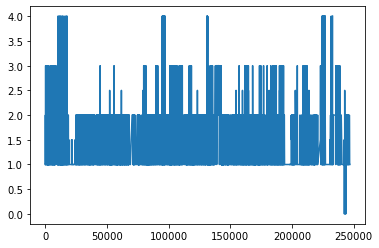

In [82]:
ls_zonal_stats_df['median'].plot();

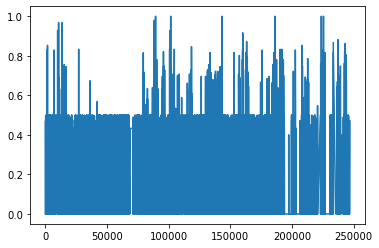

In [83]:
ls_zonal_stats_df['std'].plot();

In [84]:
b_mulfam_r['ls_class_mean'] = ls_zonal_stats_df['mean']
b_mulfam_r.head()

,BLDG_TYPE,BLDG_USE,BLDG_SQFT,Shape_Leng,Shape_Area,geometry,area,centroid,area diff,buffer_D,centroid_buffer,ls_rio_sample,ls_class_mean
97,Apartment Complex,Multi Family Residential,4801.0,167.466408,910.854747,"MULTIPOLYGON (((519218.677 5049543.114, 519222...",445.610775,POINT (519227.672 5049522.418),0.413008,16.842940,"POLYGON ((519244.515 5049522.418, 519244.434 5...",1.0,1.0
102,Duplex,Multi Family Residential,3020.0,77.472361,285.440784,"MULTIPOLYGON (((518339.648 5049100.463, 518340...",139.663033,POINT (518340.580 5049091.297),140.901813,9.429329,"POLYGON ((518350.009 5049091.297, 518349.964 5...",1.0,1.0
105,Duplex,Multi Family Residential,3367.0,74.369329,319.858534,"MULTIPOLYGON (((519603.909 5045691.371, 519610...",156.673327,POINT (519613.273 5045689.548),156.128605,9.987059,"POLYGON ((519623.260 5045689.548, 519623.212 5...",2.0,2.0
132,Apartment Complex,Multi Family Residential,2784.0,116.154005,528.670379,"MULTIPOLYGON (((519406.967 5049933.042, 519408...",258.604442,POINT (519405.404 5049924.641),0.035469,12.830928,"POLYGON ((519418.235 5049924.641, 519418.173 5...",2.0,2.0
174,Multiplex,Multi Family Residential,2985.0,103.539271,564.981863,"MULTIPOLYGON (((518589.605 5049359.402, 518600...",276.415723,POINT (518602.664 5049361.040),0.897543,13.265433,"POLYGON ((518615.929 5049361.040, 518615.865 5...",1.0,1.0


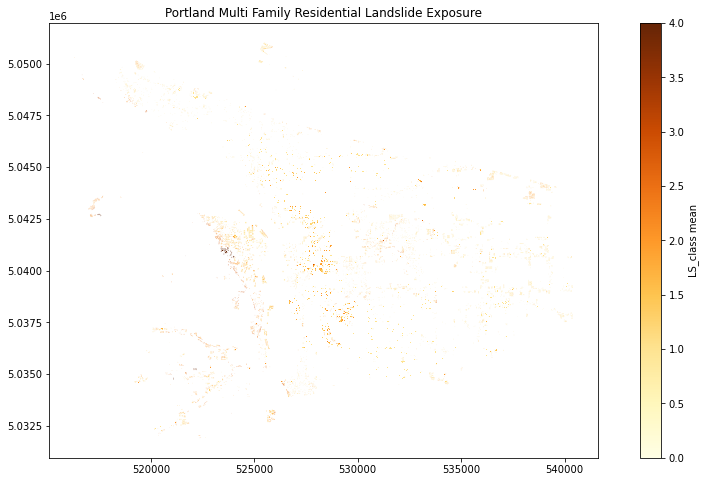

In [85]:
# %matplotlib widget
f, ax = plt.subplots(figsize=(15,8))
# ax.imshow(ls_ma, extent=po_ma_extent, cmap = 'gray')
ax.set_title('Portland Multi Family Residential Landslide Exposure')
b_mulfam_r.plot(ax=ax, column = 'ls_class_mean', cmap='YlOrBr', legend=True, legend_kwds={'label': 'LS_class mean'});

In [86]:
b_mulfam_r['ls_class_median'] = ls_zonal_stats_df['median']
b_mulfam_r.head()

,BLDG_TYPE,BLDG_USE,BLDG_SQFT,Shape_Leng,Shape_Area,geometry,area,centroid,area diff,buffer_D,centroid_buffer,ls_rio_sample,ls_class_mean,ls_class_median
97,Apartment Complex,Multi Family Residential,4801.0,167.466408,910.854747,"MULTIPOLYGON (((519218.677 5049543.114, 519222...",445.610775,POINT (519227.672 5049522.418),0.413008,16.842940,"POLYGON ((519244.515 5049522.418, 519244.434 5...",1.0,1.0,1.0
102,Duplex,Multi Family Residential,3020.0,77.472361,285.440784,"MULTIPOLYGON (((518339.648 5049100.463, 518340...",139.663033,POINT (518340.580 5049091.297),140.901813,9.429329,"POLYGON ((518350.009 5049091.297, 518349.964 5...",1.0,1.0,1.0
105,Duplex,Multi Family Residential,3367.0,74.369329,319.858534,"MULTIPOLYGON (((519603.909 5045691.371, 519610...",156.673327,POINT (519613.273 5045689.548),156.128605,9.987059,"POLYGON ((519623.260 5045689.548, 519623.212 5...",2.0,2.0,2.0
132,Apartment Complex,Multi Family Residential,2784.0,116.154005,528.670379,"MULTIPOLYGON (((519406.967 5049933.042, 519408...",258.604442,POINT (519405.404 5049924.641),0.035469,12.830928,"POLYGON ((519418.235 5049924.641, 519418.173 5...",2.0,2.0,2.0
174,Multiplex,Multi Family Residential,2985.0,103.539271,564.981863,"MULTIPOLYGON (((518589.605 5049359.402, 518600...",276.415723,POINT (518602.664 5049361.040),0.897543,13.265433,"POLYGON ((518615.929 5049361.040, 518615.865 5...",1.0,1.0,1.0


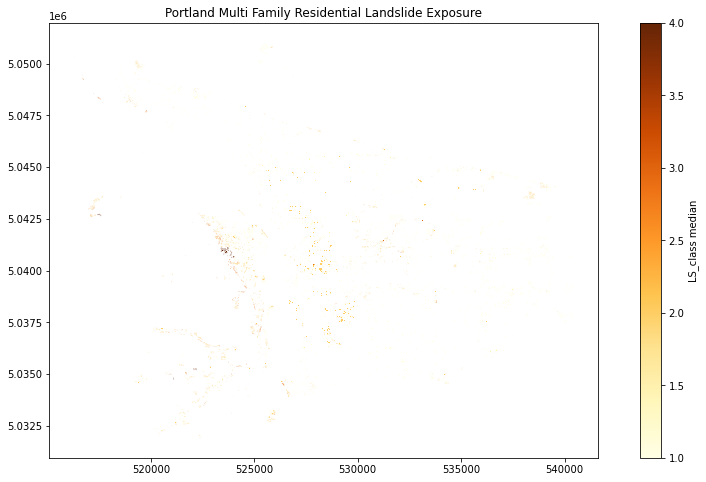

In [87]:
# %matplotlib widget
f, ax = plt.subplots(figsize=(15,8))
# ax.imshow(ls_ma, extent=po_ma_extent, cmap = 'gray')
ax.set_title('Portland Multi Family Residential Landslide Exposure')
b_mulfam_r.plot(ax=ax, column = 'ls_class_median', cmap='YlOrBr', vmin= 1.0, legend=True, legend_kwds={'label': 'LS_class median'});

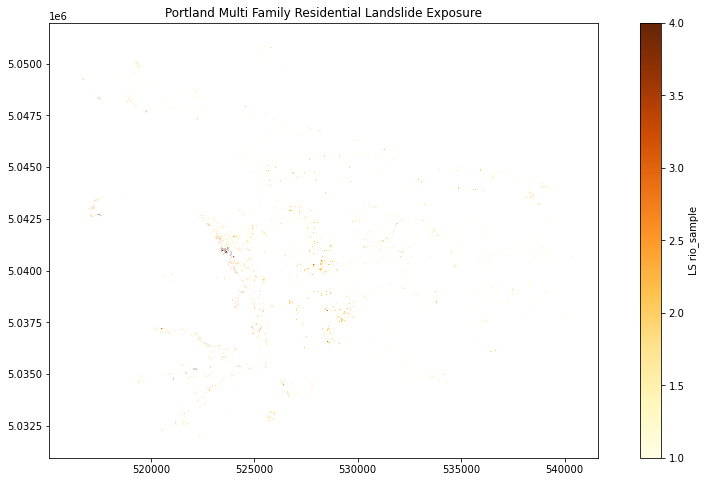

In [88]:
# Same exercise without buffer
# %matplotlib widget
f, ax = plt.subplots(figsize=(15,8))
# ax.imshow(ls_ma, extent=po_ma_extent, cmap = 'gray')
ax.set_title('Portland Multi Family Residential Landslide Exposure')
b_mulfam_r.plot(ax=ax, column = 'ls_rio_sample', cmap='YlOrBr', vmin=1.0, legend=True, legend_kwds={'label': 'LS rio_sample'});

In [89]:
b_mulfam_r['ls_rio_sample'].value_counts

<bound method IndexOpsMixin.value_counts of 97        1.0
102       1.0
105       2.0
132       2.0
174       1.0
         ... 
246600    1.0
246624    2.0
246708    1.0
246781    1.0
246957    2.0
Name: ls_rio_sample, Length: 16297, dtype: float64>

In [90]:
b_mulfam_r['ls_class_median'].value_counts

<bound method IndexOpsMixin.value_counts of 97        1.0
102       1.0
105       2.0
132       2.0
174       1.0
         ... 
246600    1.0
246624    2.0
246708    1.0
246781    1.0
246957    1.0
Name: ls_class_median, Length: 16297, dtype: float64>

<AxesSubplot:>

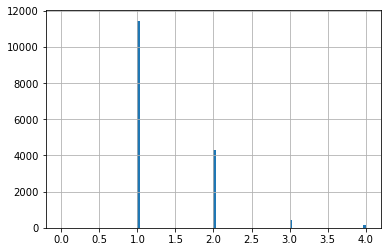

In [91]:
%matplotlib inline
b_mulfam_r['ls_rio_sample'].hist(bins=128)

In [92]:
idx_ma = b_mulfam_r['ls_rio_sample'] < 1.0
b_mulfam_r['ls_rio_sample'].count()

16297

In [93]:
# b_mulfam_r['ls_rio_sample'][idx_ma] =np.nan

In [94]:
b_mulfam_r.head()

,BLDG_TYPE,BLDG_USE,BLDG_SQFT,Shape_Leng,Shape_Area,geometry,area,centroid,area diff,buffer_D,centroid_buffer,ls_rio_sample,ls_class_mean,ls_class_median
97,Apartment Complex,Multi Family Residential,4801.0,167.466408,910.854747,"MULTIPOLYGON (((519218.677 5049543.114, 519222...",445.610775,POINT (519227.672 5049522.418),0.413008,16.842940,"POLYGON ((519244.515 5049522.418, 519244.434 5...",1.0,1.0,1.0
102,Duplex,Multi Family Residential,3020.0,77.472361,285.440784,"MULTIPOLYGON (((518339.648 5049100.463, 518340...",139.663033,POINT (518340.580 5049091.297),140.901813,9.429329,"POLYGON ((518350.009 5049091.297, 518349.964 5...",1.0,1.0,1.0
105,Duplex,Multi Family Residential,3367.0,74.369329,319.858534,"MULTIPOLYGON (((519603.909 5045691.371, 519610...",156.673327,POINT (519613.273 5045689.548),156.128605,9.987059,"POLYGON ((519623.260 5045689.548, 519623.212 5...",2.0,2.0,2.0
132,Apartment Complex,Multi Family Residential,2784.0,116.154005,528.670379,"MULTIPOLYGON (((519406.967 5049933.042, 519408...",258.604442,POINT (519405.404 5049924.641),0.035469,12.830928,"POLYGON ((519418.235 5049924.641, 519418.173 5...",2.0,2.0,2.0
174,Multiplex,Multi Family Residential,2985.0,103.539271,564.981863,"MULTIPOLYGON (((518589.605 5049359.402, 518600...",276.415723,POINT (518602.664 5049361.040),0.897543,13.265433,"POLYGON ((518615.929 5049361.040, 518615.865 5...",1.0,1.0,1.0


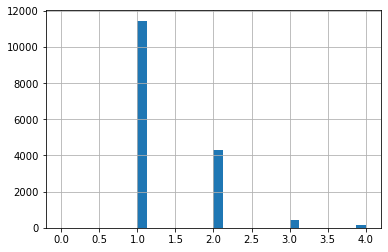

In [95]:
%matplotlib inline
b_mulfam_r['ls_rio_sample'].hist(bins=32);

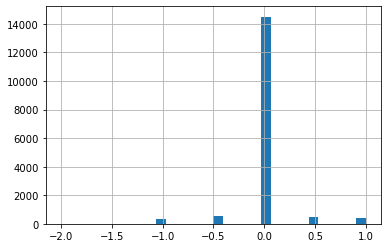

In [96]:
b_mulfam_r['median_vs_rio_sample'] = b_mulfam_r['ls_rio_sample'] - b_mulfam_r['ls_class_median']
b_mulfam_r['median_vs_rio_sample'].hist(bins=32);

In [97]:
b_mulfam_stats = b_mulfam_r.groupby('ls_rio_sample').agg('sum')
b_mulfam_stats.head()

,BLDG_SQFT,Shape_Leng,Shape_Area,area,area diff,buffer_D,ls_class_mean,ls_class_median,median_vs_rio_sample
ls_rio_sample,,,,,,,,,
0.0,14857.0,3.967517e+02,2.256317e+03,1.103488e+03,2.767605e+02,52.981946,0.166667,0.0,0.0
1.0,75329418.0,1.200807e+06,6.507718e+06,3.192473e+06,3.806782e+06,140890.693151,12225.592532,11899.5,-550.5
2.0,33272820.0,4.698264e+05,2.618294e+06,1.284845e+06,1.807493e+06,54940.344034,7913.682926,8093.0,475.0
3.0,2875335.0,4.685072e+04,2.570422e+05,1.261475e+05,1.409777e+05,5484.778463,1139.158767,1162.0,86.0
4.0,1839383.0,1.558059e+04,9.979548e+04,4.896318e+04,1.219197e+05,1834.541518,521.365079,523.0,1.0


In [98]:
b_mulfam_stats['area'].sum()

4653532.711984256

In [99]:
b_mulfam_r['area'].sum()

4653532.7119842395

In [100]:
b_mulfam_stats1 = b_mulfam_r.groupby('ls_class_median').agg('sum')
b_mulfam_stats1

,BLDG_SQFT,Shape_Leng,Shape_Area,area,area diff,buffer_D,ls_rio_sample,ls_class_mean,median_vs_rio_sample
ls_class_median,,,,,,,,,
0.0,14857.0,3.967517e+02,2.256317e+03,1.103488e+03,2.767605e+02,52.981946,0.0,0.166667,0.0
1.0,74311613.0,1.159241e+06,6.360575e+06,3.120265e+06,3.785651e+06,135812.266055,11202.0,11406.105568,319.0
1.5,4036325.0,7.923014e+04,3.790616e+05,1.859746e+05,1.890092e+05,9794.933288,1275.0,1313.020833,-36.0
2.0,29393820.0,4.281088e+05,2.383079e+06,1.169465e+06,1.561287e+06,49903.337920,7480.0,7378.140968,-252.0
2.5,488343.0,9.665304e+03,4.858236e+04,2.384304e+04,2.152513e+04,1185.024069,254.0,245.133333,6.5
3.0,2537015.0,3.749346e+04,2.078764e+05,1.020148e+05,1.336796e+05,4337.148442,958.0,939.033521,-26.0
4.0,1838126.0,1.551524e+04,9.955845e+04,4.884668e+04,1.219194e+05,1825.929888,520.0,518.365079,0.0


In [101]:
b_mulfam_stats1['area'].sum()

4651512.827569723

In [102]:
ls_ma_hist = np.ravel(ls_ma)

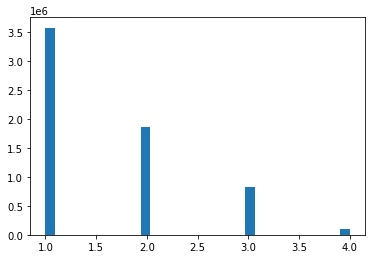

In [103]:
plt.hist(ls_ma_hist, bins=32)
plt.show()

In [104]:
b_mulfam_r.shape

(16297, 15)

In [105]:
# geom_test = b_mulfam_r.loc[97].geometry

In [106]:
# geom_test_gdf = gpd.GeoSeries(geom_test)

In [107]:
# f, ax=plt.subplots()
# geom_test_gdf.plot(ax=ax)
# geom_test_gdf.centroid.buffer(15).plot(ax=ax, color='k', alpha=0.5);

In [108]:
po_ma_extent

(510319.3414050439, 541706.5319543732, 5031044.498087207, 5055524.507531572)

In [109]:
# geom_test_gdf.total_bounds

In [110]:
# example_extent = (geom_test_gdf.total_bounds[0], geom_test_gdf.total_bounds[2], geom_test_gdf.total_bounds[1], geom_test_gdf.total_bounds[3])
# example_extent

In [111]:
ls_zonal_stats_2 = rasterstats.zonal_stats(b_mulfam_r['geometry'], ls_ma, \
                                           affine=po_ma_transform, nodata=src_proj.nodata, stats=stats)

In [112]:
ls_zonal_stats_2_df = pd.DataFrame(ls_zonal_stats_2, index=b_mulfam_r['geometry'].index)
ls_zonal_stats_2_df.describe()

,mean,count,std,median
count,15136.000000,16297.000000,15136.000000,15136.000000
mean,1.357282,2.857949,0.088832,1.353759
std,0.542450,3.291964,0.187069,0.561868
min,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000,1.000000
50%,1.000000,2.000000,0.000000,1.000000
75%,1.750000,3.000000,0.000000,2.000000
max,4.000000,70.000000,1.000000,4.000000


In [113]:
ls_zonal_stats_df.describe()

,mean,count,std,median
count,16184.000000,16297.000000,16184.000000,16184.000000
mean,1.347007,5.706204,0.139397,1.339440
std,0.514029,6.342457,0.215027,0.551861
min,0.000000,0.000000,0.000000,0.000000
25%,1.000000,3.000000,0.000000,1.000000
50%,1.000000,4.000000,0.000000,1.000000
75%,1.666667,7.000000,0.400000,2.000000
max,4.000000,135.000000,1.000000,4.000000


In [114]:
ls_zonal_stats_df['median'].value_counts

<bound method IndexOpsMixin.value_counts of 97        1.0
102       1.0
105       2.0
132       2.0
174       1.0
         ... 
246600    1.0
246624    2.0
246708    1.0
246781    1.0
246957    1.0
Name: median, Length: 16297, dtype: float64>

In [115]:
ls_zonal_stats_2_df['median'].value_counts

<bound method IndexOpsMixin.value_counts of 97        1.0
102       1.0
105       2.0
132       2.0
174       1.0
         ... 
246600    1.0
246624    2.0
246708    1.0
246781    1.0
246957    2.0
Name: median, Length: 16297, dtype: float64>

### II. Working with Single Family Residential buildings
#### Assign Landslide Susceptibility class exploring:
* Rio Sample
* Buffer
* Multipolygons shape

In [116]:
# geometry area and centroid // Adding columns
b_sinfam_r['area']= b_sinfam_r.geometry.area
b_sinfam_r['centroid']= b_sinfam_r.geometry.centroid

In [117]:
# geometry area and centroid // Adding columns
b_sinfam_r['area']= b_sinfam_r.geometry.area
b_sinfam_r['centroid']= b_sinfam_r.geometry.centroid

In [118]:
c_sinfam = b_sinfam_r['centroid']
# Coordinates to pass rio sample
b_xy_sinfam = [(pt.x, pt.y) for pt in c_sinfam.geometry]

In [119]:
# rio sample
b_sinfam_sample = np.fromiter(src_proj.sample(b_xy_sinfam), dtype=ls_ma.dtype) 

In [120]:
b_sinfam_sample = b_sinfam_sample.astype(float)
b_sinfam_sample[b_sinfam_sample == src_proj.nodata] = np.nan

In [121]:
b_sinfam_r['ls_rio_sample'] = b_sinfam_sample
b_sinfam_r.head()

,BLDG_TYPE,BLDG_USE,BLDG_SQFT,Shape_Leng,Shape_Area,geometry,area,centroid,ls_rio_sample
0,House,Single Family Residential,1324.0,82.255414,310.967219,"MULTIPOLYGON (((519808.722 5049380.495, 519804...",152.139377,POINT (519803.165 5049378.541),1.0
1,Garage,Single Family Residential,554.0,44.618188,121.956227,"MULTIPOLYGON (((520433.102 5047667.249, 520436...",59.699265,POINT (520435.835 5047662.429),1.0
2,House,Single Family Residential,1384.0,81.154237,300.281235,"MULTIPOLYGON (((518747.096 5049273.640, 518749...",146.916295,POINT (518743.312 5049265.288),1.0
3,None,Single Family Residential,2325.0,84.873482,442.060692,"MULTIPOLYGON (((516952.255 5052732.744, 516947...",216.044367,POINT (516943.669 5052726.563),1.0
4,House,Single Family Residential,688.0,63.291208,205.587118,"MULTIPOLYGON (((518933.860 5049769.035, 518935...",100.570121,POINT (518934.086 5049762.521),1.0


In [122]:
# Zonal Stats to 'geometry' attribute
ls_zonal_stats_sinfam_2 = rasterstats.zonal_stats(b_sinfam_r['geometry'], ls_ma, \
                                           affine=po_ma_transform, nodata=src_proj.nodata, stats=stats)

In [123]:
ls_zonal_stats_df_sinfam_2 = pd.DataFrame(ls_zonal_stats_sinfam_2, index=b_sinfam_r['geometry'].index)
ls_zonal_stats_df_sinfam_2.head()

,mean,count,std,median
0,1.0,2,0.0,1.0
1,1.0,1,0.0,1.0
2,1.0,1,0.0,1.0
3,1.0,2,0.0,1.0
4,1.0,1,0.0,1.0


In [124]:
# Defining buffer
b_sinfam_r['buffer_D'] = np.sqrt(2*b_sinfam_r['area']/np.pi)
# Defining buffer variables
c_sinfam = b_sinfam_r['centroid']
buffer_D_sinfam = b_sinfam_r['buffer_D']
# Adding to the gdf columns
b_sinfam_r['centroid_buffer']= c_sinfam.buffer(buffer_D_sinfam)
b_sinfam_r.head()

,BLDG_TYPE,BLDG_USE,BLDG_SQFT,Shape_Leng,Shape_Area,geometry,area,centroid,ls_rio_sample,buffer_D,centroid_buffer
0,House,Single Family Residential,1324.0,82.255414,310.967219,"MULTIPOLYGON (((519808.722 5049380.495, 519804...",152.139377,POINT (519803.165 5049378.541),1.0,9.841491,"POLYGON ((519813.007 5049378.541, 519812.959 5..."
1,Garage,Single Family Residential,554.0,44.618188,121.956227,"MULTIPOLYGON (((520433.102 5047667.249, 520436...",59.699265,POINT (520435.835 5047662.429),1.0,6.164879,"POLYGON ((520442.000 5047662.429, 520441.970 5..."
2,House,Single Family Residential,1384.0,81.154237,300.281235,"MULTIPOLYGON (((518747.096 5049273.640, 518749...",146.916295,POINT (518743.312 5049265.288),1.0,9.671082,"POLYGON ((518752.983 5049265.288, 518752.936 5..."
3,None,Single Family Residential,2325.0,84.873482,442.060692,"MULTIPOLYGON (((516952.255 5052732.744, 516947...",216.044367,POINT (516943.669 5052726.563),1.0,11.727665,"POLYGON ((516955.397 5052726.563, 516955.340 5..."
4,House,Single Family Residential,688.0,63.291208,205.587118,"MULTIPOLYGON (((518933.860 5049769.035, 518935...",100.570121,POINT (518934.086 5049762.521),1.0,8.001558,"POLYGON ((518942.087 5049762.521, 518942.049 5..."


In [125]:
# Zonal Stats to 'centroid buffer' attribute
ls_zonal_stats_sinfam = rasterstats.zonal_stats(b_sinfam_r['centroid_buffer'], ls_ma, \
                                           affine=po_ma_transform, nodata=src_proj.nodata, stats=stats)

In [126]:
ls_zonal_stats_df_sinfam_1 = pd.DataFrame(ls_zonal_stats_sinfam, index=b_sinfam_r['geometry'].index)
ls_zonal_stats_df_sinfam_1.head()

,mean,count,std,median
0,1.0,4,0.0,1.0
1,1.0,2,0.0,1.0
2,1.0,3,0.0,1.0
3,1.0,4,0.0,1.0
4,1.5,2,0.5,1.5


In [127]:
# Assign to a column
b_sinfam_r['ls_class_median'] = ls_zonal_stats_df_sinfam_1['median']

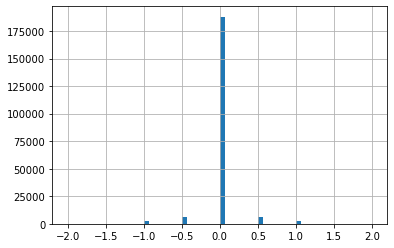

In [128]:
# Differences:
b_sinfam_r['median_vs_rio_sample'] = b_sinfam_r['ls_rio_sample'] - b_sinfam_r['ls_class_median']
b_sinfam_r['median_vs_rio_sample'].hist(bins=64);

In [129]:
b_sinfam_stats = b_sinfam_r.groupby('ls_rio_sample').agg('sum')
b_sinfam_stats.head()

,BLDG_SQFT,Shape_Leng,Shape_Area,area,buffer_D,ls_class_median,median_vs_rio_sample
ls_rio_sample,,,,,,,
0.0,1687378.0,5.677286e+04,2.776601e+05,1.347322e+05,7.184768e+03,5.0,-5.0
1.0,395891906.0,1.170488e+07,6.196746e+07,3.037049e+07,1.477070e+06,153414.0,-4779.0
2.0,122259953.0,3.828919e+06,1.733721e+07,8.505467e+06,4.824547e+05,92313.0,3563.0
3.0,20684624.0,5.350471e+05,2.578841e+06,1.261478e+06,6.646367e+04,17327.5,741.5
4.0,3745833.0,1.249314e+05,5.944973e+05,2.916571e+05,1.526134e+04,5349.0,11.0


## V. INTERPRETATION
* Percent of residential buildings exposed to each class

In [130]:
# Using rio sample values:
b_mulfam_stats['% of area in ls_class'] = 100*round(b_mulfam_stats['area']/b_mulfam_stats['area'].sum(),2)
b_sinfam_stats['% of area in ls_class'] = 100*round(b_sinfam_stats['area']/b_sinfam_stats['area'].sum(),2)

In [131]:
# Merge both dataframe with concatenate
merge_stats = [b_mulfam_stats, b_sinfam_stats]
b_residential_concat = pd.concat(merge_stats, join="inner")
# b_residential_concat = b_mulfam_stats.append(b_sinfam_stats)

In [132]:
b_residential_concat

,BLDG_SQFT,Shape_Leng,Shape_Area,area,buffer_D,ls_class_median,median_vs_rio_sample,% of area in ls_class
ls_rio_sample,,,,,,,,
0.0,14857.0,3.967517e+02,2.256317e+03,1.103488e+03,5.298195e+01,0.0,0.0,0.0
1.0,75329418.0,1.200807e+06,6.507718e+06,3.192473e+06,1.408907e+05,11899.5,-550.5,69.0
2.0,33272820.0,4.698264e+05,2.618294e+06,1.284845e+06,5.494034e+04,8093.0,475.0,28.0
3.0,2875335.0,4.685072e+04,2.570422e+05,1.261475e+05,5.484778e+03,1162.0,86.0,3.0
4.0,1839383.0,1.558059e+04,9.979548e+04,4.896318e+04,1.834542e+03,523.0,1.0,1.0
0.0,1687378.0,5.677286e+04,2.776601e+05,1.347322e+05,7.184768e+03,5.0,-5.0,0.0
1.0,395891906.0,1.170488e+07,6.196746e+07,3.037049e+07,1.477070e+06,153414.0,-4779.0,75.0
2.0,122259953.0,3.828919e+06,1.733721e+07,8.505467e+06,4.824547e+05,92313.0,3563.0,21.0
3.0,20684624.0,5.350471e+05,2.578841e+06,1.261478e+06,6.646367e+04,17327.5,741.5,3.0


In [133]:
b_residential_concat['% of total in ls_class'] = 100*round(b_residential_concat['area']/b_residential_concat['area'].sum(),2)
b_residential_concat

,BLDG_SQFT,Shape_Leng,Shape_Area,area,buffer_D,ls_class_median,median_vs_rio_sample,% of area in ls_class,% of total in ls_class
ls_rio_sample,,,,,,,,,
0.0,14857.0,3.967517e+02,2.256317e+03,1.103488e+03,5.298195e+01,0.0,0.0,0.0,0.0
1.0,75329418.0,1.200807e+06,6.507718e+06,3.192473e+06,1.408907e+05,11899.5,-550.5,69.0,7.0
2.0,33272820.0,4.698264e+05,2.618294e+06,1.284845e+06,5.494034e+04,8093.0,475.0,28.0,3.0
3.0,2875335.0,4.685072e+04,2.570422e+05,1.261475e+05,5.484778e+03,1162.0,86.0,3.0,0.0
4.0,1839383.0,1.558059e+04,9.979548e+04,4.896318e+04,1.834542e+03,523.0,1.0,1.0,0.0
0.0,1687378.0,5.677286e+04,2.776601e+05,1.347322e+05,7.184768e+03,5.0,-5.0,0.0,0.0
1.0,395891906.0,1.170488e+07,6.196746e+07,3.037049e+07,1.477070e+06,153414.0,-4779.0,75.0,67.0
2.0,122259953.0,3.828919e+06,1.733721e+07,8.505467e+06,4.824547e+05,92313.0,3563.0,21.0,19.0
3.0,20684624.0,5.350471e+05,2.578841e+06,1.261478e+06,6.646367e+04,17327.5,741.5,3.0,3.0


In [134]:
b_residential_concat['% of total in ls_class'].sum()

100.0

In [135]:
b_mulfam_stats.head()

,BLDG_SQFT,Shape_Leng,Shape_Area,area,area diff,buffer_D,ls_class_mean,ls_class_median,median_vs_rio_sample,% of area in ls_class
ls_rio_sample,,,,,,,,,,
0.0,14857.0,3.967517e+02,2.256317e+03,1.103488e+03,2.767605e+02,52.981946,0.166667,0.0,0.0,0.0
1.0,75329418.0,1.200807e+06,6.507718e+06,3.192473e+06,3.806782e+06,140890.693151,12225.592532,11899.5,-550.5,69.0
2.0,33272820.0,4.698264e+05,2.618294e+06,1.284845e+06,1.807493e+06,54940.344034,7913.682926,8093.0,475.0,28.0
3.0,2875335.0,4.685072e+04,2.570422e+05,1.261475e+05,1.409777e+05,5484.778463,1139.158767,1162.0,86.0,3.0
4.0,1839383.0,1.558059e+04,9.979548e+04,4.896318e+04,1.219197e+05,1834.541518,521.365079,523.0,1.0,1.0


In [136]:
b_sinfam_stats.head()

,BLDG_SQFT,Shape_Leng,Shape_Area,area,buffer_D,ls_class_median,median_vs_rio_sample,% of area in ls_class
ls_rio_sample,,,,,,,,
0.0,1687378.0,5.677286e+04,2.776601e+05,1.347322e+05,7.184768e+03,5.0,-5.0,0.0
1.0,395891906.0,1.170488e+07,6.196746e+07,3.037049e+07,1.477070e+06,153414.0,-4779.0,75.0
2.0,122259953.0,3.828919e+06,1.733721e+07,8.505467e+06,4.824547e+05,92313.0,3563.0,21.0
3.0,20684624.0,5.350471e+05,2.578841e+06,1.261478e+06,6.646367e+04,17327.5,741.5,3.0
4.0,3745833.0,1.249314e+05,5.944973e+05,2.916571e+05,1.526134e+04,5349.0,11.0,1.0


In [137]:
b_sinfam_stats['area'].sum()

40563826.56072951

In [138]:
b_sinfam_r['area'].sum()

40563826.56072967

In [139]:
b_mulfam_r['area'].sum()

4653532.7119842395

In [140]:
b_mulfam_stats['area'].sum()

4653532.711984256

In [141]:
b_sinfam_stats_count = b_sinfam_r.groupby('ls_rio_sample').agg('count')
b_sinfam_stats_count.head()

,BLDG_TYPE,BLDG_USE,BLDG_SQFT,Shape_Leng,Shape_Area,geometry,area,centroid,buffer_D,centroid_buffer,ls_class_median,median_vs_rio_sample
ls_rio_sample,,,,,,,,,,,,
0.0,1,770,769,770,770,770,770,770,770,770,758,758
1.0,136185,163343,161680,163343,163343,163343,163343,163343,163343,163343,148635,148635
2.0,44512,51416,50973,51416,51416,51416,51416,51416,51416,51416,47938,47938
3.0,5409,6238,6202,6238,6238,6238,6238,6238,6238,6238,6023,6023
4.0,1144,1395,1382,1395,1395,1395,1395,1395,1395,1395,1340,1340


In [142]:
b_mulfam_stats_count = b_mulfam_r.groupby('ls_rio_sample').agg('count')
b_mulfam_stats_count.head()

,BLDG_TYPE,BLDG_USE,BLDG_SQFT,Shape_Leng,Shape_Area,geometry,area,centroid,area diff,buffer_D,centroid_buffer,ls_class_mean,ls_class_median,median_vs_rio_sample
ls_rio_sample,,,,,,,,,,,,,,
0.0,4,4,4,4,4,4,4,4,4,4,4,4,4,4
1.0,11237,11442,11441,11442,11442,11442,11442,11442,11441,11442,11442,11349,11349,11349
2.0,4202,4304,4303,4304,4304,4304,4304,4304,4303,4304,4304,4284,4284,4284
3.0,403,416,416,416,416,416,416,416,416,416,416,416,416,416
4.0,121,131,131,131,131,131,131,131,131,131,131,131,131,131


In [143]:
b_residential_stats_area = b_residential_concat.groupby('ls_rio_sample').agg('sum')
b_residential_stats_area

,BLDG_SQFT,Shape_Leng,Shape_Area,area,buffer_D,ls_class_median,median_vs_rio_sample,% of area in ls_class,% of total in ls_class
ls_rio_sample,,,,,,,,,
0.0,1702235.0,5.716962e+04,2.799165e+05,1.358357e+05,7.237750e+03,5.0,-5.0,0.0,0.0
1.0,471221324.0,1.290569e+07,6.847518e+07,3.356297e+07,1.617960e+06,165313.5,-5329.5,144.0,74.0
2.0,155532773.0,4.298746e+06,1.995551e+07,9.790312e+06,5.373951e+05,100406.0,4038.0,49.0,22.0
3.0,23559959.0,5.818978e+05,2.835883e+06,1.387625e+06,7.194845e+04,18489.5,827.5,6.0,3.0
4.0,5585216.0,1.405120e+05,6.942928e+05,3.406203e+05,1.709588e+04,5872.0,12.0,2.0,1.0


In [144]:
merge_stats_count = [b_mulfam_stats_count, b_sinfam_stats_count]
b_residential_concat_count = pd.concat(merge_stats_count, join="inner")
b_residential_stats_count = b_residential_concat_count.groupby('ls_rio_sample').agg('sum')
b_residential_stats_count

,BLDG_TYPE,BLDG_USE,BLDG_SQFT,Shape_Leng,Shape_Area,geometry,area,centroid,buffer_D,centroid_buffer,ls_class_median,median_vs_rio_sample
ls_rio_sample,,,,,,,,,,,,
0.0,5,774,773,774,774,774,774,774,774,774,762,762
1.0,147422,174785,173121,174785,174785,174785,174785,174785,174785,174785,159984,159984
2.0,48714,55720,55276,55720,55720,55720,55720,55720,55720,55720,52222,52222
3.0,5812,6654,6618,6654,6654,6654,6654,6654,6654,6654,6439,6439
4.0,1265,1526,1513,1526,1526,1526,1526,1526,1526,1526,1471,1471


In [145]:
b_residential_stats_count = 100*round(b_residential_concat_count['BLDG_USE']/b_residential_concat_count['BLDG_USE'].sum(),2)
b_residential_stats_count

ls_rio_sample
0.0     0.0
1.0     5.0
2.0     2.0
3.0     0.0
4.0     0.0
0.0     0.0
1.0    68.0
2.0    21.0
3.0     3.0
4.0     1.0
Name: BLDG_USE, dtype: float64

<ipython-input-147-823c12f6184d>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lbl)


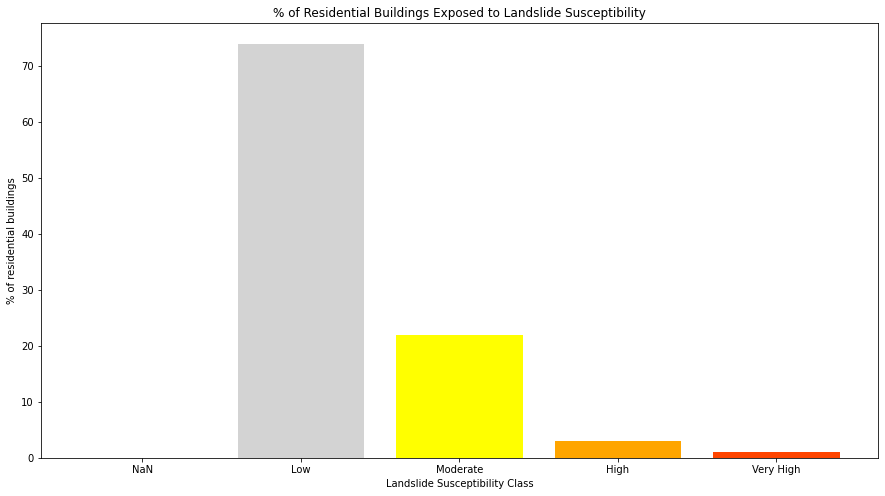

In [147]:
# Representing results
result = np.array(b_residential_stats_area['% of total in ls_class'])
x_axis = ([0,1,2,3,4])
lbl = (['', 'NaN', 'Low', 'Moderate', 'High', 'Very High'])
colors = ['k', 'lightgray','yellow','orange','orangered']
f, ax=plt.subplots(figsize=(15,8))
plt.bar(x_axis, result, color=colors, align='center')
ax.set_xticklabels(lbl)
plt.title('% of Residential Buildings Exposed to Landslide Susceptibility')
plt.xlabel('Landslide Susceptibility Class')
plt.ylabel('% of residential buildings');

In [148]:
b_residential_stats_area['% of total in ls_class'].describe

<bound method NDFrame.describe of ls_rio_sample
0.0     0.0
1.0    74.0
2.0    22.0
3.0     3.0
4.0     1.0
Name: % of total in ls_class, dtype: float64>

## Conclusions
* 74% of residential buildings fall under low susceptibility class
* 22% of residential buildings fall under Moderate susceptibility class
* 3% of residential buildings fall under High susceptibility class
* 1% of residential buildings fall under Very High susceptibility class

### Further Research
* Statistics based on Building types
* Using probability of landslide over time
* Economic impacts (Annual Loss)